# 1. Variational Autoencoder

In [1]:
import os
os.chdir('./1. GAN/')

1) Import Libraries

In [225]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import torch
from torchvision import datasets
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

2) CUDA Setting

In [226]:
# CUDA setting
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"CUDA GPU : {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')

CUDA GPU : NVIDIA GeForce RTX 4070 Ti SUPER


3) Dataset Download & Parse

In [249]:
# Dataset download (MNIST)

BATCH_SIZE = 1000
    
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_data =  datasets.MNIST('./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
test_loader =  torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

4) Model Archtecture & Structure - Generator

In [271]:
class Generator(nn.Module):
	def __init__(self, d_noise, d_hidden):
		super(Generator, self).__init__()
		
		self.G = nn.Sequential(
			nn.Linear(d_noise, 2 * d_hidden),
			nn.ReLU(),
			nn.Dropout(0.2),
			nn.Linear(2 * d_hidden, d_hidden),
			nn.ReLU(),
			nn.Dropout(0.2),
			nn.Linear(d_hidden, d_hidden),
			nn.ReLU(),
			nn.Dropout(0.2),
			nn.Linear(d_hidden, 28*28),
			nn.Tanh()
		)
	
	def forward(self, x):
		x = self.G(x)
		return x

4) Model Archtecture & Structure - Discriminator

In [345]:
class Discriminator(nn.Module):
	def __init__(self, d_noise, d_hidden):
		super(Discriminator, self).__init__()

		self.D = nn.Sequential(
			nn.Linear(784, 2 * d_hidden),
			nn.ReLU(),
			nn.Dropout(0.2),
			nn.Linear(2 * d_hidden, d_hidden),
			nn.ReLU(),
			nn.Dropout(0.2),
			nn.Linear(d_hidden, d_hidden),
			nn.ReLU(),
			nn.Dropout(0.2),
			nn.Linear(d_hidden, 1),
			nn.Sigmoid()
		)
	
	def forward(self, x):
		x = self.D(x)
		return x

5) Training defined model

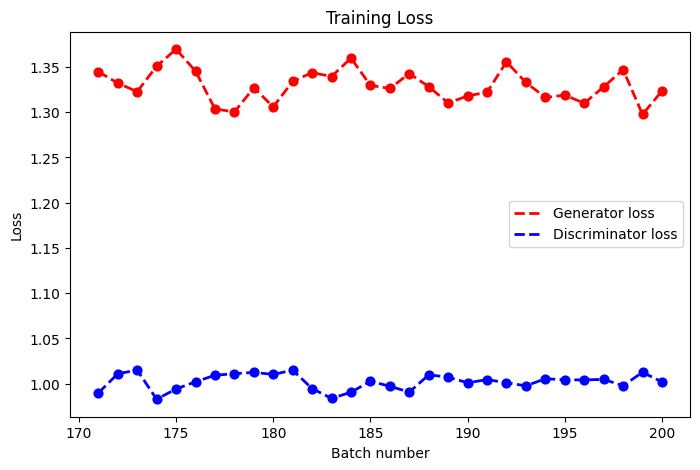

100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [03:24<00:00,  1.02s/it]


In [425]:
from IPython import display

gen_model = Generator(d_noise=100, d_hidden=256).to(device)
dis_model = Discriminator(d_noise=100, d_hidden=256).to(device)

gen_model.train()
dis_model.train()

gen_lr = 2E-4
dis_lr = 2E-4

gen_optim = torch.optim.Adam(gen_model.parameters(), lr=gen_lr)
dis_optim = torch.optim.Adam(dis_model.parameters(), lr=dis_lr)

loss_fn = nn.BCELoss()
gen_losses = []
dis_losses = []

epoch = 200

for epoch_idx in trange(epoch):
    running_gen_loss = 0.0
    running_dis_loss = 0.0

    total_batches = 0

    for (X, _) in train_loader:
        X = X.to(device)
        X = X.view(-1, 784)

        ##### Training Discriminator #####
        real_labels = torch.ones(BATCH_SIZE, 1).to(device)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(device)
        
        # for real datas
        real_res = dis_model(X) # D(real)
        real_loss = loss_fn(real_res, real_labels)

        fake_res = dis_model(gen_model(torch.randn(BATCH_SIZE, 100).to(device))) # D(G(fake))
        fake_loss = loss_fn(fake_res, fake_labels)

        dis_loss = real_loss + fake_loss
        running_dis_loss += dis_loss.item()

        dis_optim.zero_grad()
        dis_loss.backward()
        dis_optim.step()

        ##### Training Generator #####
        gen_res = dis_model(gen_model(torch.randn(BATCH_SIZE, 100).to(device))) # D(G(fake)) 로 generator 학습

        gen_loss = loss_fn(gen_res, real_labels)
        running_gen_loss += gen_loss.item()

        gen_optim.zero_grad()
        gen_loss.backward()
        gen_optim.step()

        total_batches += 1

    gen_losses.append(running_gen_loss / total_batches)
    dis_losses.append(running_dis_loss / total_batches)

    display.clear_output(wait=True)
    plt.figure(figsize=(8, 5))

    xrange = [i for i in range(1, epoch_idx+2)]
    if len(xrange) > 30:
        xrange = xrange[-30:]
        gen_yrange = gen_losses[xrange[0]-1:xrange[-1]]
        dis_yrange = dis_losses[xrange[0]-1:xrange[-1]]
    else:
        gen_yrange = gen_losses[:]
        dis_yrange = dis_losses[:]
    
    plt.plot(xrange, gen_yrange, linestyle='--', linewidth=2, c='r', label='Generator loss')
    plt.scatter(xrange, gen_yrange, c='red', s=40)

    plt.plot(xrange, dis_yrange, linestyle='--', linewidth=2, c='b', label='Discriminator loss')
    plt.scatter(xrange, dis_yrange, c='b', s=40)

    plt.xlabel('Batch number')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()

6) Visualization of my model

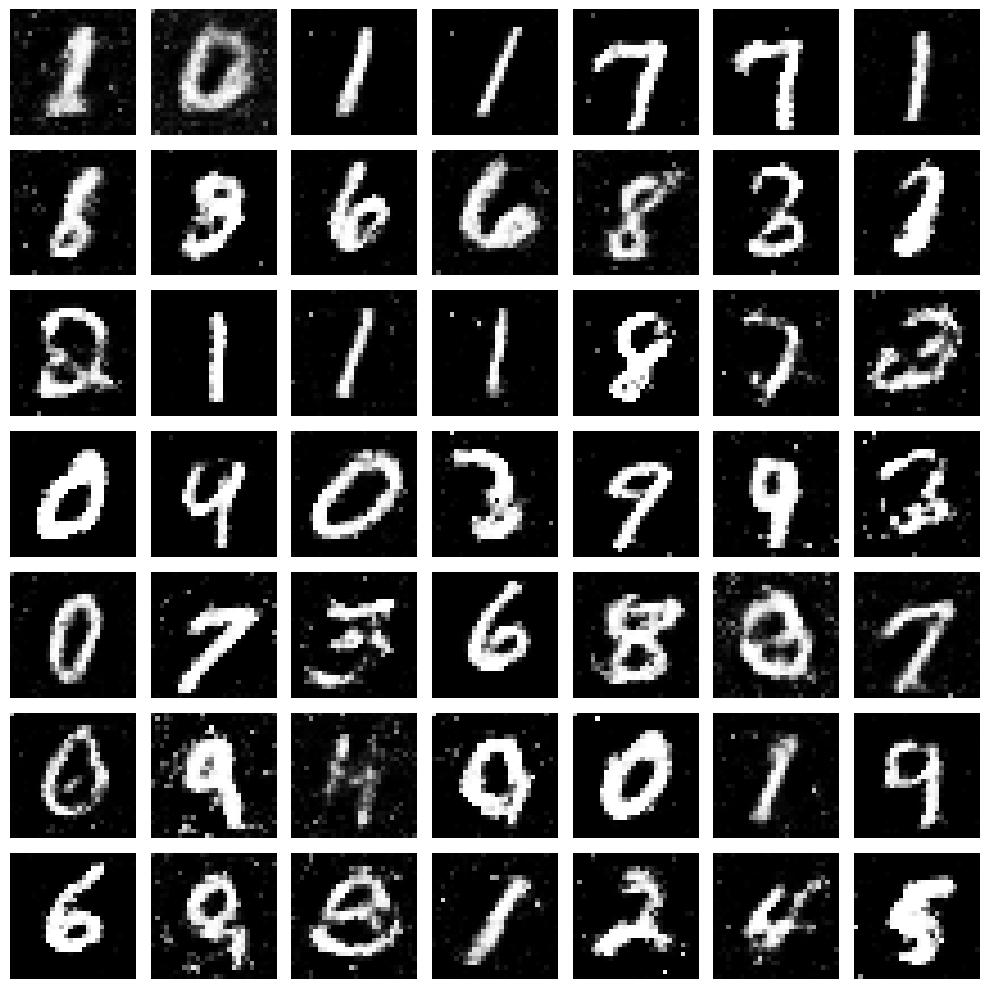

In [439]:
import torch
import matplotlib.pyplot as plt

# Assume `gen_model` is already defined and moved to the appropriate device
# Assume `device` is already defined (e.g., 'cuda' or 'cpu')

# Define the number of images
num_images = 49

# Initialize a figure for plotting
fig, axs = plt.subplots(7, 7, figsize=(10, 10))

# Generate and display images
for i in range(num_images):
    # Generate a random noise vector and create an image
    noise = torch.randn(1, 100).to(device)  # Use the appropriate input size
    with torch.no_grad():
        gen_img = gen_model(noise).cpu().detach().numpy()
    
    # Reshape the generated image
    gen_img = gen_img.reshape(28, 28)
    
    # Calculate row and column in the 7x7 grid
    row = i // 7
    col = i % 7
    
    # Display the image in the appropriate subplot
    axs[row, col].imshow(gen_img, cmap='gray')
    axs[row, col].axis('off')  # Turn off the axis

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
